In [1]:
import numpy as np
import torch
import math

EVALUATION_MODE = True
if EVALUATION_MODE:
    from torch import nn
    from torch import optim
    from torch.nn import functional as F
    import math
    import time #used for benchmarking
    from tqdm.notebook import tqdm
    import matplotlib 
    from matplotlib import pyplot as plt


Base class for all modules

In [2]:
class Module (object):
    def forward(self, *input):
        raise NotImplementedError

    def __call__(self, x):
        return self.forward(x)
        
    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    def zero_grad(self):
        raise NotImplementedError

    def param(self):
        return []

# Activation functions

In [3]:
class Activation(Module):
    def forward(self, x):
        self.x = x
    
    def backward(self, *gradwrtoutput):
        pass

    def requires_grad(self):
        return False

    def zero_grad(self):
        self.x = 0

In [4]:
class ReLU(Activation):        
    def forward(self, x):
        super().forward(x)
        return x * (x > 0)
    
    def backward(self, *output_grad):
        return (self.x > 0) * output_grad[-1]

class Tanh(Activation):
    def forward(self, x):
        super().forward(x)
        return (2 / (1 + (-2*x).exp())) - 1
    
    def backward(self, *output_grad):
        return (1 - self.forward(self.x)**2) * output_grad[-1]

# Linear Layers

In [5]:
class Linear(Module):
    def __init__(self, in_size, out_size, init_method = None):
        # initialization
        std = math.sqrt(1 / in_size)
        self.weights = torch.empty(in_size, out_size).uniform_(-std, std)
        self.bias = torch.empty(1, out_size).uniform_(-std, std)
        
    def forward(self, x):
        self.x = x
        return (x @ self.weights) + self.bias

    def backward(self, *output_grad):
        self.dw = self.x.t() @ output_grad[-1]
        self.db = output_grad[-1].sum(axis=0)
        return output_grad[-1] @ self.weights.t()
    
    def step(self, lr, wd):
        self.weights.add_(-lr * self.dw - lr * wd * self.weights)
        self.bias.add_(-lr * self.db - lr * wd * self.bias)

    def requires_grad(self):
        return True
    
    def zero_grad(self):
        self.dw =0
        self.db = 0

In [6]:
class Sequential(Module):
    def __init__(self, *layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, *output_grad):
        grad_list = [output_grad[-1]]
        for layer in self.layers[::-1]:
            grad_list.append(layer.backward(grad_list[-1]))         
        return output_grad[0]

    def parameters(self):
        return self.layers

# Optimizer

In [7]:
class Optimizer(object):
    def __init__(self, layers, lr):
        self.lr = lr
        self.layers = layers
        
    def step(self):
        raise NotImplementedError

class SGD(Optimizer):
    def __init__(self, model, lr, weight_decay = 0):
        super().__init__(model, lr)
        self.weight_decay = weight_decay

    def zero_grad(self):
        for layer in self.layers:
            layer.zero_grad()
        
    def step (self):
        for layer in self.layers:
            if layer.requires_grad():
                layer.step(self.lr, self.weight_decay)

# Loss functions

In [8]:
class Loss(object):
    def loss(self, predicted, labels):
        raise NotImplementedError
    def __call__(self, predicted, labels):
        return self.loss(predicted, labels)
    def dloss(self, predicted, target):
        raise NotImplementedError

In [9]:
class MSELoss(Loss):
    def loss(self, predicted, labels):
        return ((predicted - labels)**2).mean()
    
    def dloss(self, predicted, labels):
        return 2 * (predicted - labels)/(len(predicted))

# Training

You must implement a test executable named test.py that imports your framework and
* Generates a training and a test set of 1, 000 points sampled uniformly in \[0, 1\]^2,  each with a label 0 if outside the disk centered at (0.5, 0.5) of radius 1/√2π, and 1 inside
* builds a network with two input units, one output unit, three hidden layers of 25 units,
* trains it with MSE, logging the loss,
* computes and prints the final train and the test errors

In [10]:
def compute_error_ratio(predicted, labels):
    e = 0
    if predicted.shape != labels.shape:
        (predicted.argmax(axis=1) != labels)*1/predicted.shape[0]
    else:
        e = 1 - (torch.round(predicted) == labels).float().mean()
    return e

In [11]:
def generate_data(nb):
    train_input = torch.rand(nb,2)
    train_target = torch.empty(nb, dtype=torch.long)
    train_target = train_input.sub(0.5).pow(2).sum(1).sub(1 / (2*math.pi)).sign().add(1).div(2).float().view(-1,1)
    return train_input, train_target

## Train the model

In [12]:
def train_model(model, optimizer, criterion, train_input, train_target, mini_batch_size=100, epochs=100, is_custom=True):
    tr_losses, te_losses = torch.empty((epochs,1)), torch.empty((epochs,1)) #Training loss over epochs

    for epoch in range(epochs):
        for inputs, labels in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size)):

            # reset optimizer, forward and compute loss 
            optimizer.zero_grad()
            predicted = model(inputs)
            loss = criterion(predicted, labels)

            # calculate gradients (using backward on the model for custom and autograd.backward for torch)
            if is_custom:
                dloss = criterion.dloss(predicted, labels)
                model.backward(dloss)
            else:
                loss.backward()
            optimizer.step()
            
            err = compute_error_ratio(predicted, labels)
        tr_losses[epoch] = loss
    return tr_losses, te_losses

In [13]:
# MODELS TO COMPARE 
ROUNDS = 50
NB_SAMPLE = 1000
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.001

NUMBERS=False

BASIC_MODEL_DESC = [('lin', 2, 25), ('relu'), ('lin', 25, 10), ('relu'), ('lin', 10, 25), ('relu'), ('lin', 25, 1)]

def layer_selection(layerp, custom):
    if len(layerp) == 3 and layerp[0] == 'lin':
        layer = Linear if custom else nn.Linear
        return layer(layerp[1], layerp[2])
    if layerp == 'relu':
        layer = ReLU if custom else nn.ReLU
        return layer()
    return None

def create_model_optimizer_criterion(model_description, custom=True):
    SEQU, OPTI, CRIT = None, None, None
    if custom:
        SEQU, OPTI, CRIT = Sequential, SGD, MSELoss
    else:
        SEQU, OPTI, CRIT = nn.Sequential, optim.SGD, nn.MSELoss
    layers = [ layer_selection(layerp, custom) for layerp in model_description]
    model = SEQU(*layers)
    return (model, OPTI(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY), CRIT())

## Evaluate model
We repeat the training for n rounds in order to get mean/std trainings. 

In [14]:
def evaluate_model(datasets, model_description, rounds=10, epochs = 10, is_custom = True, lr = None, wd = None):

    train_input, train_target, test_input, test_target = datasets

    tr_error, te_error = torch.empty((rounds,1)), torch.empty((rounds,1))
    tr_losses, te_losses = torch.empty((rounds, epochs)), torch.empty((rounds, epochs))
    
    for r in tqdm(range(rounds)):
        
        # Generate model and training/test data
        model, optimizer, criterion = create_model_optimizer_criterion(model_description, custom=is_custom)
        torch.set_grad_enabled(not is_custom)
        
        # Train model
        tr_loss, te_loss = train_model(model, optimizer, criterion, train_input, train_target, epochs=epochs, is_custom=is_custom)
        predicted_test = model(test_input)
        predicted_train = model(train_input)
        
        # Compute error rate
        err_test = compute_error_ratio(predicted_test, test_target)
        err_train = compute_error_ratio(predicted_train, train_target)
        
        # Save all data
        tr_losses[r], te_losses[r] = tr_loss.t(), te_loss.t()
        tr_error[r], te_error[r] = err_train, err_test
        
    return torch.mean(tr_error), torch.std(tr_error), torch.mean(te_error), torch.std(te_error), torch.mean(tr_losses, axis = 0) 

We actually get the error-rate mean and std & plot the training loss evolution during training

In [15]:
def store():
    it = 0
    while os.path.isfile('data/dataframe/db{}.pkl'.format(it)):
        it+=1
    outfile = open(f'data/dataframe/db{it}.pkl', 'wb')
    pickle.dump(DATABASE, outfile)
    outfile.close()

def load(new=False):
    it = 0
    while os.path.isfile('data/dataframe/db{}.pkl'.format(it)):
        it+=1
    return pd.read_pickle(f'data/dataframe/db{it-1}.pkl') if (it>0 and new==False) else pd.DataFrame([], columns = cols)

def plot_loss(*idx, custom=None):
    for idx_i in idx:
        df = DATABASE[ DATABASE['id'].between(idx_i-0.000001,idx_i+0.000001)]
        li = [True, False] if custom == None else [custom]
        for tr in li:
            s =  df[df['custom_framework'] == tr]['loss'].values[0]
            plt.plot(s, label = "{} id:{}".format("Custom Framework" if True else 'Torch framework', idx_i))
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Training loss')

def print_report(*idx):
    for idx_i in idx:
        df = DATABASE[ DATABASE['id'].between(idx_i-0.000001,idx_i+0.000001)]
        print('Run with parameters: ')
        print('\t - DATASET_SIZE: {}, \t results averaged on {} ROUNDS'.format(df['samples'].unique().item(), df['rounds'].unique().item()))
        print('\t - model parameters: {}'.format(str(df['model_description'].to_numpy()[0])))
        print('\t - optimizer parameters: LEARNING_RATE: {} \t WEIGHT_DECAY: {}'.format(df['learning_rate'].unique().item(), df['weight_decay'].unique().item()))
        print("Results: ")
        s =  df[df['custom_framework'] == True]
        print("\t - CUSTOM FRAMEWORK: \t training:  {:.3f} +/-  {:.3f} \t test: {:.3f} +/-  {:.3f} \t computed in {} s".format(s['tr_mean'].unique().item(), s['tr_std'].unique().item(), s['te_mean'].unique().item(), s['te_std'].unique().item(), s['duration'].unique().item()))
        s =  df[df['custom_framework'] == False]
        print("\t - TORCH FRAMEWORK: \t training:  {:.3f} +/-  {:.3f} \t test: {:.3f} +/-  {:.3f} \t computed in {} s".format(s['tr_mean'].unique().item(), s['tr_std'].unique().item(), s['te_mean'].unique().item(), s['te_std'].unique().item(), s['duration'].unique().item()))
        print()


Training Custom framework



Training Pytorch framework


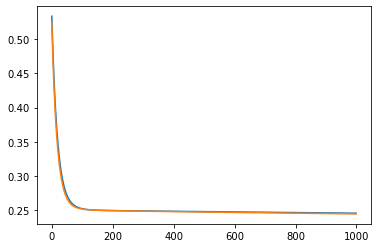

In [20]:
import matplotlib 
from matplotlib import pyplot as plt
import time
from tqdm.notebook import tqdm
import os.path
import pickle
import seaborn as sns
from random import random
import pandas as pd
import itertools

cols = ['custom_framework','rounds', 'samples', 'learning_rate', 'weight_decay', 'loss', 'tr_mean', 'tr_std', 'te_mean', 'te_std', 'duration', 'id', 'model_description']

ROUNDS = 25
NB_SAMPLE = 100
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0
EPOCHS = 1000
UNIQ_ID = random()

dict_models = {"Custom framework" : True, "Pytorch framework" : False}

lr_list = [LEARNING_RATE]# [0.0001, 0.001, 0.01, 0.1, 0.5]
wd_list = [WEIGHT_DECAY] #[0, 0.0001, 0.001, 0.01, 0.1]
hl_list = [5]#[2, 10, 25]

# generate training and testing data
train_input, train_target = generate_data(NB_SAMPLE)
test_input, test_target = generate_data(NB_SAMPLE)
datasets = (train_input, train_target, test_input, test_target)
DATABASE = load(new=True)


for params in itertools.product(lr_list, wd_list, hl_list):
    
    UNIQ_ID = random()
    MODEL_DESCR = [('lin', 2, params[2]), ('relu'), ('lin', params[2], params[2]), ('relu'), ('lin', params[2], 1)]
    LEARNING_RATE = params[0]
    WEIGHT_DECAY = params[1]

    plt.figure()
    for key in dict_models.keys():
        
        print("Training {}".format(key))
        start = time.perf_counter()
        tr_mean, tr_std, te_mean, te_std, tr_loss = evaluate_model(datasets, rounds = ROUNDS, epochs=EPOCHS, is_custom=dict_models[key], model_description=MODEL_DESCR)
        avg_time = (time.perf_counter() - start) / ROUNDS

        DATABASE = DATABASE.append(dict(zip(cols, [dict_models[key], ROUNDS, NB_SAMPLE, LEARNING_RATE, WEIGHT_DECAY, tr_loss.detach().numpy(), tr_mean.item(), tr_std.item(), te_mean.item(), te_std.item(), avg_time, UNIQ_ID, MODEL_DESCR])), ignore_index=True)
        plt.plot(tr_loss.detach(), label = "{}".format(key))

    # Save the result into a dataframe
    store()

# plot the figure
# print_report(UNIQ_ID)
# plot_loss(UNIQ_ID)

In [17]:
DATABASE.head(20)

,custom_framework,rounds,samples,learning_rate,weight_decay,loss,tr_mean,tr_std,te_mean,te_std,duration,id,model_description
0,True,10,100,0.0001,0,"[0.9857451, 0.98495114, 0.9841588, 0.98336804,...",0.500,0.000000,0.446,0.075895,0.526144,0.355063,"[(lin, 2, 2), relu, (lin, 2, 2), relu, (lin, 2..."
1,False,10,100,0.0001,0,"[0.98914814, 0.9887288, 0.98830986, 0.9878913,...",0.552,0.157537,0.508,0.191067,0.672403,0.355063,"[(lin, 2, 2), relu, (lin, 2, 2), relu, (lin, 2..."


Run with parameters: 
	 - DATASET_SIZE: 100, 	 results averaged on 50 ROUNDS
	 - model parameters: [('lin', 2, 25), 'relu', ('lin', 25, 25), 'relu', ('lin', 25, 1)]
	 - optimizer parameters: LEARNING_RATE: 0.01 	 WEIGHT_DECAY: 0
Results: 
	 - CUSTOM FRAMEWORK: 	 training:  0.328 +/-  0.079 	 test: 0.417 +/-  0.057 	 computed in 0.5536541859999852 s
	 - TORCH FRAMEWORK: 	 training:  0.323 +/-  0.082 	 test: 0.409 +/-  0.067 	 computed in 0.789679071999999 s



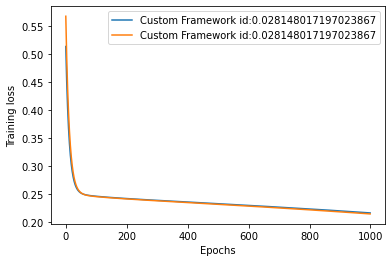

In [18]:
print_report(UNIQ_ID)
plot_loss(UNIQ_ID)

# Test of convolutional layers 

In [19]:
class FlattenLayer(Activation):
    def __init__(self):
        self._shape = ()

    def forward(self, a_prev):
        self._shape = a_prev.shape
        return torch.ravel(a_prev).reshape(a_prev.shape[0], -1)

    def backward(self, *outputgrad):
        da_curr = outputgrad[-1]
        return da_curr.reshape(self._shape)

    def requires_grad(self):
        return False

In [26]:
class ConvLayer2D(Module):

    def __init__(self, w, b, padding: str = 'valid', stride: int = 1):
        self._w, self._b = w, b
        self._padding = padding
        self._stride = stride
        self._dw, self._db = None, None
        self._a_prev = None
        self._cols = None

    @classmethod
    def initialize(cls, filters: int, kernel_shape, padding: str = 'valid', stride: int = 1):
        # w = torch.random(*kernel_shape, filters) * 0.1
        
        std = math.sqrt(1 / 10)
        w = torch.empty(*kernel_shape, filters).uniform_(-std, std)
        b = torch.empty(filters).uniform_(-std, std)
        # w = torch.rand(*kernel_shape, filters) * 0.1
        # b = torch.rand(filters) * 0.1

        return cls(w=w, b=b, padding=padding, stride=stride)

    def weights(self):
        return self._w, self._b

    def gradients(self):
        if self._dw is None or self._db is None:
            return None
        return self._dw, self._db

    def step(self, lr, wd):
        self._w.add_(-lr * self._dw - lr * wd * self._w)
        self._b.add_(-lr * self._db - lr * wd * self._b)

    def forward(self, a_prev):
        self._a_prev = a_prev
        output_shape = self.calculate_output_dims(input_dims=a_prev.shape)
        n, h_in, w_in, _ = a_prev.shape
        _, h_out, w_out, _ = output_shape
        h_f, w_f, _, n_f = self._w.shape
        pad = self.calculate_pad_dims()
        a_prev_pad = self.pad(array=a_prev, pad=pad)
        output = torch.zeros(output_shape)

        for i in range(h_out):
            for j in range(w_out):
                h_start = i * self._stride
                h_end = h_start + h_f
                w_start = j * self._stride
                w_end = w_start + w_f

                output[:, i, j, :] = torch.sum( a_prev_pad[:, h_start:h_end, w_start:w_end, :, np.newaxis] * self._w[np.newaxis, :, :, :], axis=(1, 2, 3))

        return output + self._b

    def zero_grad(self):
        self._dw =0
        self._db = 0

    def backward(self, *outputgrad):

        da_curr = outputgrad[-1]

        _, h_out, w_out, _ = da_curr.shape
        n, h_in, w_in, _ = self._a_prev.shape
        h_f, w_f, _, _ = self._w.shape
        pad = self.calculate_pad_dims()
        a_prev_pad = self.pad(array=self._a_prev, pad=pad)
        output = torch.zeros_like(a_prev_pad, dtype=float)

        self._db = da_curr.sum(axis=(0, 1, 2)) / n
        self._dw = torch.zeros_like(self._w)

        for i in range(h_out):
            for j in range(w_out):
                h_start = i * self._stride
                h_end = h_start + h_f
                w_start = j * self._stride
                w_end = w_start + w_f
                output[:, h_start:h_end, w_start:w_end, :] += torch.sum(
                    self._w.unsqueeze(0)*da_curr[:, i:i+1, j:j+1].unsqueeze(3),
                    axis=4
                    )
                self._dw += torch.sum(
                    a_prev_pad[:, h_start:h_end, w_start:w_end].unsqueeze(4) *
                    da_curr[:, i:i+1, j:j+1].unsqueeze(3),
                    axis=0
                )
        self._dw /= n
        return output[:, pad[0]:pad[0]+h_in, pad[1]:pad[1]+w_in, :]


    def set_wights(self, w, b):
        self._w = w
        self._b = b

    def calculate_output_dims(self, input_dims):
        n, h_in, w_in, _ = input_dims
        h_f, w_f, _, n_f = self._w.shape
        if self._padding == 'same':
            return n, h_in, w_in, n_f
        elif self._padding == 'valid':
            h_out = (h_in - h_f) // self._stride + 1
            w_out = (w_in - w_f) // self._stride + 1
            return n, h_out, w_out, n_f
        else:
            raise InvalidPaddingModeError(
                f"Unsupported padding value: {self._padding}"
            )

    def calculate_pad_dims(self):
        if self._padding == 'same':
            h_f, w_f, _, _ = self._w.shape
            return (h_f - 1) // 2, (w_f - 1) // 2
        elif self._padding == 'valid':
            return 0, 0
        else:
            raise InvalidPaddingModeError(
                f"Unsupported padding value: {self._padding}"
            )

    @staticmethod
    def pad(array, pad):
        return torch.tensor(np.pad(
            array=array,
            pad_width=((0, 0), (pad[0], pad[0]), (pad[1], pad[1]), (0, 0)),
            mode='constant'
        ))

    def requires_grad(self):
        return True
    
    def zero_grad(self):
        self._dw =0
        self._db = 0


In [21]:
def softmax(x):
        a,_ = torch.max(x, dim = 1)
        expo = torch.exp(x - a.view(-1,1))
        return expo /torch.sum(expo, dim = 1).view(-1,1)

def to_hot_encoding(target):
    res = torch.zeros((target.shape[0], 10))
    for i in range(target.shape[0]):
        res[i,target[i]] = 1
    return res

class CrossEntropyLoss(Loss):
    def loss(self,predicted, targets):
        target = to_hot_encoding(targets)
        a,_ = torch.max(predicted, dim = 1)
        loss = - (predicted*target).sum(dim = 1)
        loss += a
        loss += torch.log((predicted - a.view(-1,1)).exp().sum(dim=1))        
        return loss.mean(dim = 0)
    
    def dloss(self,predicted, targets):
        target = to_hot_encoding(targets)
        dloss = softmax(predicted) - target
        return dloss/len(predicted)

In [22]:
# MODELS TO COMPARE 
ROUNDS = 50
NB_SAMPLE = 1000
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.001

NUMBERS=False

BASIC_MODEL_DESC = [('lin', 2, 25), ('relu'), ('lin', 25, 10), ('relu'), ('lin', 10, 25), ('relu'), ('lin', 25, 1)]

def layer_selection(layerp, custom):
    if len(layerp) == 3 and layerp[0] == 'lin':
        layer = Linear if custom else nn.Linear
        return layer(layerp[1], layerp[2])
    if len(layerp) == 3 and  layerp[0] == 'conv':
        return ConvLayer2D.initialize(filters=layerp[1], kernel_shape=layerp[2], stride=1, padding="same")
    if layerp == 'relu':
        layer = ReLU if custom else nn.ReLU
        return layer()
    if layerp == 'flat':
        layer = FlattenLayer if custom else nn.Flatten
        return layer()

    return None

def create_model_optimizer_criterion(model_description, custom=True):
    SEQU, OPTI, CRIT = None, None, None
    if custom:
        SEQU, OPTI, CRIT = Sequential, SGD, CrossEntropyLoss
    else:
        SEQU, OPTI, CRIT = nn.Sequential, optim.SGD, nn.MSELoss
    layers = [ layer_selection(layerp, custom) for layerp in model_description]
    model = SEQU(*layers)
    return (model, OPTI(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY), CRIT())

In [27]:
from dlc_practical_prologue import generate_pair_sets

cols = ['custom_framework','rounds', 'samples', 'learning_rate', 'weight_decay', 'loss', 'tr_mean', 'tr_std', 'te_mean', 'te_std', 'duration', 'id', 'model_description']
ROUNDS = 1
N = 1000
NB_SAMPLE = 1000
LEARNING_RATE = 0.1
EPOCHS= 10
WEIGHT_DECAY = 0
UNIQ_ID = random()

# generate training and testing data
train_input_, train_target_, train_classes_, test_input_, test_target_, test_classes_ = generate_pair_sets(N)
train_input, train_target = train_input_.unsqueeze(4)[:,0], train_classes_[:,0]
test_input, test_target = test_input_.unsqueeze(4)[:,0], test_classes_[:,0]
datasets = (train_input, train_target, test_input, test_target)
DATABASE = load(new=True)
NUMERS=True

MODEL_DESCR = [('conv', 16, (3,3,1) ), ('relu'),('conv', 32, (3,3,16) ), ('relu'), ('flat'),('lin', 6272, 25), ('relu'),('lin', 25, 25), ('relu'), ('lin', 25, 10)]

plt.figure()
    
print("Training {}".format(key))
start = time.perf_counter()
tr_mean, tr_std, te_mean, te_std, tr_loss = evaluate_model(datasets, rounds = ROUNDS, is_custom=True, model_description=MODEL_DESCR)
avg_time = (time.perf_counter() - start) / ROUNDS

DATABASE = DATABASE.append(dict(zip(cols, [True, ROUNDS, NB_SAMPLE, LEARNING_RATE, WEIGHT_DECAY, tr_loss.detach().numpy(), tr_mean.item(), tr_std.item(), te_mean.item(), te_std.item(), avg_time, UNIQ_ID, MODEL_DESCR])), ignore_index=True)

# plot the figure
print_report(UNIQ_ID)
plot_loss(UNIQ_ID, custom=True)

Training Custom framework



Run with parameters: 
	 - DATASET_SIZE: 1000, 	 results averaged on 1 ROUNDS
	 - model parameters: [('conv', 16, (3, 3, 1)), 'relu', ('conv', 32, (3, 3, 16)), 'relu', 'flat', ('lin', 6272, 25), 'relu', ('lin', 25, 25), 'relu', ('lin', 25, 10)]
	 - optimizer parameters: LEARNING_RATE: 0.1 	 WEIGHT_DECAY: 0
Results: 
	 - CUSTOM FRAMEWORK: 	 training:  0.000 +/-  nan 	 test: 0.000 +/-  nan 	 computed in 88.87320829999953 s


ValueError: can only convert an array of size 1 to a Python scalar

In [28]:
DATABASE.head()

,custom_framework,rounds,samples,learning_rate,weight_decay,loss,tr_mean,tr_std,te_mean,te_std,duration,id,model_description
0,True,1,1000,0.1,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.0,NaN,0.0,NaN,88.873208,0.094123,"[(conv, 16, (3, 3, 1)), relu, (conv, 32, (3, 3..."
